In [1]:
import pandas as pd
import numpy as np
import time
import unicodedata
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException, WebDriverException

import datetime
from datetime import timedelta, datetime

import csv
import os

import sys
sys.path.append('./lib/')

from functions import *
import functions

from tqdm import tnrange, tqdm_notebook
from unidecode import unidecode

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import lxml.html
import lxml

import glob

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

%load_ext autoreload

%autoreload 2

In [2]:
pattern = 'output/**/*.csv'
pattern = 'output/scraped_data_20170417.csv'

files = glob.glob(pattern, recursive=True)
files
    

['output/scraped_data_20170417.csv']

In [3]:
col_names = ['entity', 'department', 'contract', 'year', 'month', 'group', 'lastn', 'lastn2', 'givenn', 'degree', 
             'qualif', 'position', 'region', 'specials', 'currency', 'salary', 'overt', 'start_date', 'end_date', 'obs', 'url', 'other']
len(col_names)

22

In [4]:

dfscraped = pd.DataFrame()

for f in files:
    if( ('scraped' in f) and (not 'data_clean' in f)):
        df = pd.read_csv(f, header=None, encoding='latin1', names=col_names, warn_bad_lines=True, low_memory=False)
        df['filename'] = f
        dfscraped = pd.concat([dfscraped, df], ignore_index=True)

print(dfscraped.shape)

(2183713, 23)


In [5]:
dfscraped.filename.value_counts()

output/scraped_data_20170417.csv    2183713
Name: filename, dtype: int64

In [6]:
dfscraped.entity.value_counts()

Ministerio del Interior y Seguridad PÃºblica        563301
Ministerio de Obras PÃºblicas                       216771
Ministerio de Vivienda y Urbanismo                  194956
Ministerio de Justicia                              184507
Ministerio de Hacienda                              164059
Ministerio de EducaciÃ³n                            151345
entity                                              147542
Ministerio de EconomÃ­a, Fomento y Turismo          106665
Ministerio del Trabajo y PrevisiÃ³n Social           95891
Ministerio de Desarrollo Social                      93470
Consejo de Defensa del Estado                        52521
Ministerio de Defensa Nacional                       45285
Ministerio de Agricultura                            44495
Ministerio de MinerÃ­a                               39141
Ministerio de Relaciones Exteriores                  24826
Ministerio SecretarÃ­a General de la Presidencia     13839
Presidencia de la RepÃºblica                          79

In [7]:
dfscraped.url.nunique()

33850

## Data that was not captured with the right encoding, get again

In [8]:
retake_entity = list(dfscraped[dfscraped.entity.str.contains("b'", na=False)].entity.value_counts().index)
retake_entity = retake_entity + list(dfscraped[dfscraped.entity.str.contains("Ã", na=False)].entity.value_counts().index)
retake_entity = retake_entity + list(dfscraped[dfscraped.entity.str.contains("Ã­", na=False)].entity.value_counts().index)
retake_entity = retake_entity + ['Ministerio del Interior y Seguridad Pblica', 'Presidencia de la Repblica ']  

In [9]:
print('Total Urls', dfscraped.url.nunique())
print('Urls to retake', dfscraped[dfscraped.entity.isin(retake_entity)].url.nunique())

Total Urls 33850
Urls to retake 23263


In [10]:
retake_entity_urls = []
for u in list(set(dfscraped.ix[dfscraped.entity.isin(retake_entity), 'url'].unique())):
    if str(u) != 'nan':
        if "b'" in u:
            u = u[2:]
        if u[-1] == "'":
            u = u[:len(u)-1]
        retake_entity_urls.append(u)
len(retake_entity_urls)

3918

In [11]:
retake_entity_urls

['http://www.gobiernotransparentechile.cl/directorio/entidad/12/173/per_contrata/A%EF%BF%BDo%202011/Abril?x=0&y=0&page_number=3&sort=id&direction=asc',
 'http://www.gobiernotransparentechile.cl/directorio/entidad/12/169/per_contrata/Ao-2009?x=0&y=0&page_number=9&sort=id&direction=asc',
 'http://www.gobiernotransparentechile.cl/directorio/entidad/9/141/per_planta/Ao-2006?x=0&y=0&page_number=2&sort=id&direction=asc',
 'http://www.gobiernotransparentechile.cl/directorio/entidad/12/169/per_contrata/Ao-2010?x=0&y=0&page_number=6&sort=id&direction=asc',
 'http://www.gobiernotransparentechile.cl/directorio/entidad/2/2/per_contrata/2011/Noviembre?x=0&y=0&page_number=5&sort=id&direction=asc',
 'http://www.gobiernotransparentechile.cl/directorio/entidad/11/159/per_contrata/Ao-2008?x=0&y=0&page_number=9&sort=id&direction=asc',
 'http://www.gobiernotransparentechile.cl/directorio/entidad/2/2/per_planta/2014/Febrero?x=0&y=0&page_number=3&sort=id&direction=asc',
 'http://www.gobiernotransparentechil

### Open browser and re-scrape data 

In [12]:
output_file = output_file = './output/retake_entity_0.csv'

In [13]:
if not os.path.isfile(output_file):
    browser = webdriver.Firefox()
    for url in retake_entity_urls[0:5]:
        functions.getTableData2(output_file, url, browser)
    

In [14]:
retake_entity_df = pd.read_csv(output_file, encoding='latin1', names=col_names)

In [15]:
retake_entity_df.entity.value_counts()

Ministerio del Trabajo y Previsión Social            75041
b'Ministerio del Trabajo y Previsi\xf3n Social'      50531
b'Ministerio del Interior y Seguridad P\xfablica'    45599
Ministerio de Minería                                37565
b'Ministerio de Obras P\xfablicas'                   27766
b'Ministerio de Educaci\xf3n'                        19799
b'Ministerio de Econom\xeda, Fomento y Turismo'      14122
b'Ministerio de Justicia'                            12252
b'Ministerio de Desarrollo Social'                    9425
b'Ministerio de Defensa Nacional'                     4552
Ministerio de Energía                                 4545
Ministerio de Desarrollo Social                       4113
Ministerio de Educación                               3450
Ministerio de Justicia                                3168
Ministerio de Economía, Fomento y Turismo             3124
b'Ministerio de Salud'                                3089
Ministerio del Interior y Seguridad Pública           24

In [16]:
cleanLatin(retake_entity_df)

Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other
Could not clean column: other



### Let's delete the corresponding rows and add the new ones 

In [17]:
retake_entity_df['filename'] = output_file
print(retake_entity_df.shape)
print(dfscraped[dfscraped.entity.isin(retake_entity)].shape)
dfscraped = dfscraped[~dfscraped.entity.isin(retake_entity)]
dfscraped = pd.concat([dfscraped, retake_entity_df])
dfscraped.shape

(328844, 23)
(310284, 23)


(1917695, 23)

# Write or Read clean file 

In [11]:
write_clean_file = True
apply_cleanup_again = False



In [ ]:
if write_clean_file:
    print('Before Processing:', dfscraped.shape)
    columns_dupe = [col for col in dfscraped.columns if not 'filename' in col]
    cleanLatin(dfscraped)
    dfscraped1 = dfscraped.drop_duplicates(columns_dupe)
    print('After Processing:', dfscraped1.shape)
    
    # Lower case values
    dfscraped1.givenn = dfscraped1.givenn.str.lower()
    dfscraped1.lastn = dfscraped1.lastn.str.lower()
    dfscraped1.lastn2 = dfscraped1.lastn2.str.lower()
    
    # Write file
    dfscraped1.to_csv('./output/scraped_data_clean_20140417.csv', encoding='utf-8', index=False)
    
    
#Before Processing: (2476309, 23)

#After Processing: (2081444, 23)

Before Processing: (2183713, 23)


In [ ]:
if not write_clean_file:
    dfscraped1 = pd.read_csv('./output/scraped_data_clean.csv', encoding='latin1', low_memory=False)
    columns_dupe = [col for col in dfscraped1.columns if not 'filename' in col]

if apply_cleanup_again:
    cleanLatin(dfscraped1)
    dfscraped1.drop_duplicates(columns_dupe, inplace=True)

In [ ]:
dfscraped1.entity.replace(np.nan, -1).value_counts()

# Cleaning SENAME and learning cleaning functions

In [24]:
dfjusticia = dfscraped1.loc[dfscraped1.entity == 'Ministerio de Justicia']

In [25]:
dfjusticia.department.value_counts()

Servicio Nacional de Menores (SENAME)                  99009
Servicio de Registro Civil e Identificación (SRCEI)    78471
Defensoría Penal Pública                                3316
Name: department, dtype: int64

In [26]:
dfsename = dfjusticia.loc[dfjusticia.department == 'Servicio Nacional de Menores (SENAME)']

In [27]:
dfsename.groupby(['year', 'month'])['entity'].count()

year        month  
ABRIL       allyear    4118
AGOSTO      allyear    4389
Año 2006    allyear    2806
Año 2007    allyear    3185
Año 2008    allyear    3387
Año 2009    allyear    3499
Año 2010    allyear    3985
Año 2011    allyear    4017
Año 2012    allyear    4062
Año 2013    allyear    4831
Año 2014    allyear    4379
Año 2015    allyear    6035
Año 2016    allyear      47
DICIEMBRE   allyear    4206
ENERO       allyear    7990
FEBRERO     allyear    8113
JULIO       allyear    4324
JUNIO       allyear    4269
MARZO       allyear    4082
MAYO        allyear    4190
NOVIEMBRE   allyear    4156
OCTUBRE     allyear    4498
SEPTIEMBRE  allyear    4441
Name: entity, dtype: int64

## Year label is a month + it is Known to be from a certain year 

In [25]:
print(dfsename.shape)
# Monthly data, set define months
dfmonths = pd.read_csv('./data/months.csv', dtype={'month2' : str, 'month3' : int})
dfmonths.month3 = dfmonths.month3.astype(int)

months = list(dfmonths.month2.values)

# all the rows that are months we know they are 2016
# mark them as this transformation
dfsename.ix[:,'TmonthIsKnownYear'] = 0
dfsename.ix[dfsename.year.str.lower().isin(months), 'TmonthIsKnownYear'] = 1

# Write Months
dfsename.ix[dfsename.TmonthIsKnownYear == 1, 'month2'] = dfsename.year.str.lower()
dfsename.ix[dfsename.TmonthIsKnownYear == 0, 'month2'] = 'allyear'
dfsename = pd.merge(dfsename, dfmonths, how='left', on='month2')

# Write years
dfsename.ix[:, 'year2'] = dfsename.year.str.extract('( [0-9]*)$', expand=False)
dfsename.ix[dfsename.TmonthIsKnownYear == 1, 'year2'] = 2016
dfsename.year2 = pd.to_numeric(dfsename.year2)

# Include Rows Flag
dfsename['include'] = 1
dfsename.ix[(dfsename.year2 == 2016) & (dfsename.month2 == 'allyear'), 'include'] = 0 # year 2016
dfsename.ix[(dfsename.year == 0) | (dfsename.year == 1), 'include'] = 0 # zeroes and ones

print(dfsename.shape)

(146355, 23)


C:\Users\jgaci\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\jgaci\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(146355, 28)


In [26]:
print(dfsename.replace(np.nan, -1).groupby(['include' ,'TmonthIsKnownYear', 'year', 'year2', 'month2', 'month3'])['entity'].count())

include  TmonthIsKnownYear  year        year2  month2      month3
0        0                  Año 2016    2016   allyear     -1.0        54
1        0                  Año 2006    2006   allyear     -1.0      2808
                            Año 2007    2007   allyear     -1.0      6370
                            Año 2008    2008   allyear     -1.0      6774
                            Año 2009    2009   allyear     -1.0      5453
                            Año 2010    2010   allyear     -1.0      6190
                            Año 2011    2011   allyear     -1.0      6246
                            Año 2012    2012   allyear     -1.0      6346
                            Año 2013    2013   allyear     -1.0      7702
                            Año 2014    2014   allyear     -1.0      6785
                            Año 2015    2015   allyear     -1.0      9712
         1                  ABRIL       2016   abril        4.0      6846
                            AGOSTO      2016  

## Expand yearly data to months. Allows filtering people from months by start_date and end_date.

In [27]:
print(dfsename.shape)

# Define what df we want to expand to months
cols = [col for col in dfsename.columns if ((col !='month2') and (col != 'month3') )]
df_to_monthly = dfsename.ix[dfsename.month2 == 'allyear', cols]
print(df_to_monthly.shape)

# Keys to mege
df_to_monthly['key'] = 1
dfmonths['key'] = 1

# Generate cartesian product
dfcartesian = pd.merge(df_to_monthly, dfmonths, on='key')
cols2 = [col for col in dfcartesian.columns if col !='key']
dfcartesian = dfcartesian.ix[:,cols2]
print(dfcartesian.shape)

# Remove yearly rows
dfsename = dfsename.ix[dfsename.month2 != 'allyear', :]

# Add monthly rows
dfsename = pd.concat([dfsename, dfcartesian])

(146355, 28)
(64440, 26)
(773280, 28)


In [28]:
print(dfsename.shape)
print(dfsename.replace(np.nan, -1).groupby(['include' ,'TmonthIsKnownYear', 'year2', 'month3'])['entity'].count().unstack('year2'))

(855195, 28)
year2                               2006    2007    2008    2009    2010  \
include TmonthIsKnownYear month3                                           
0       0                 1.0        NaN     NaN     NaN     NaN     NaN   
                          2.0        NaN     NaN     NaN     NaN     NaN   
                          3.0        NaN     NaN     NaN     NaN     NaN   
                          4.0        NaN     NaN     NaN     NaN     NaN   
                          5.0        NaN     NaN     NaN     NaN     NaN   
                          6.0        NaN     NaN     NaN     NaN     NaN   
                          7.0        NaN     NaN     NaN     NaN     NaN   
                          8.0        NaN     NaN     NaN     NaN     NaN   
                          9.0        NaN     NaN     NaN     NaN     NaN   
                          10.0       NaN     NaN     NaN     NaN     NaN   
                          11.0       NaN     NaN     NaN     NaN     NaN   

In [29]:
# Set the datetimeindex index
dfsename['curDate'] = dfsename.year2.map(int).map(str) + '-' + dfsename.month3.map(int).map(str)
dfsename['curDate2'] = pd.to_datetime(dfsename.curDate, format='%Y-%m')
dfsename = dfsename.set_index(pd.DatetimeIndex(dfsename['curDate2']))


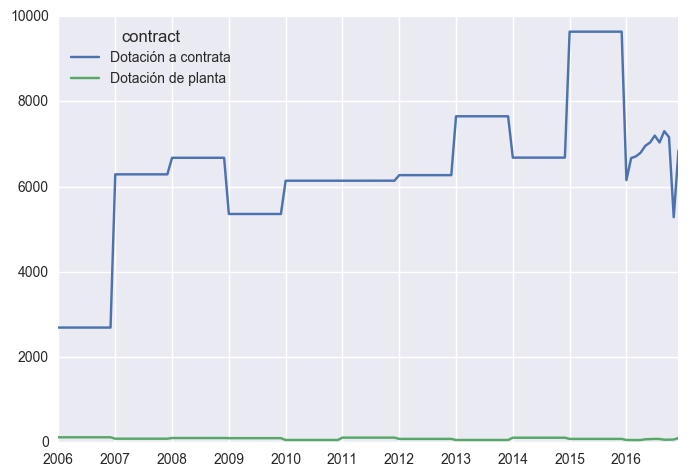

In [30]:
dfsename.ix[dfsename.include == 1].replace(np.nan, -1).groupby('contract').resample('M')['curDate2'].count().unstack('contract').plot()

Year 2016 looks weird because we have the actual monthly data. The rest of the years are just unparsed yearly data.

In [31]:
dfsename['start_date'] = dfsename['start_date'].astype(str)
dfsename['end_date'] = dfsename['end_date'].astype(str)

# Fix some guys
dfsename.start_date = dfsename.start_date.str.replace('28/10/201$', '28/10/2010')

# Transform
dfsename['start_date2'] = pd.to_datetime(dfsename['start_date'], format='%d/%m/%Y', errors='coerce')
dfsename['end_date2'] = pd.to_datetime(dfsename['end_date'], format='%d/%m/%Y', errors='coerce')


In [32]:
print('Start nulls\n', dfsename.ix[pd.isnull(dfsename.start_date2), 'start_date'].value_counts())
print('End nulls\n', dfsename.ix[pd.isnull(dfsename.end_date2), 'end_date'].value_counts())

Start nulls
 nan    397
       144
Name: start_date, dtype: int64
End nulls
 Indefinido    8633
nan            373
               144
Name: end_date, dtype: int64


In [33]:

# Finished before the report date
dfsename.ix[dfsename.end_date2 < dfsename.curDate2 + timedelta(days=14) , 'include'] = 0
# Started after the report date
dfsename.ix[dfsename.start_date2 > dfsename.curDate2 + timedelta(days=14), 'include'] = 0
# Null values
dfsename.ix[dfsename.start_date2 == 'nan', 'include'] = 0
dfsename.ix[dfsename.start_date2 == '', 'include'] = 0
# Indefinite contract
dfsename.ix[(dfsename.start_date2 <= dfsename.curDate2) & (dfsename.end_date == 'Indefinido'), 'include'] = 1

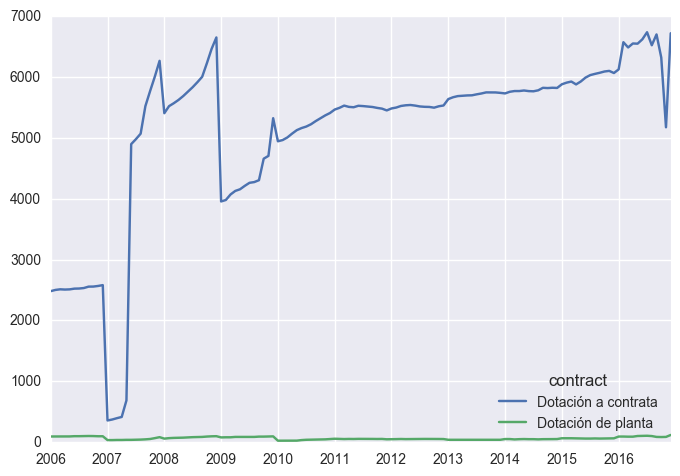

In [34]:
dfsename.ix[dfsename.include == 1].replace(np.nan, -1).groupby('contract').resample('M')['curDate2'].count().unstack('contract').plot()

In [35]:
# Percentage of included
included_pct = pd.concat([dfsename.groupby(['include', 'curDate2'])['entity'].count().unstack('include'),
                         dfsename.groupby(['include', 'curDate2'])['entity'].count().unstack('include').sum(axis=1)], axis=1, join='inner')
included_pct.columns = ['no', 'yes', 'total']
included_pct['no_pct'] = included_pct.no / included_pct.total
list(included_pct.ix[included_pct.no_pct > 0.5].index)

[Timestamp('2007-01-01 00:00:00', offset='MS'),
 Timestamp('2007-02-01 00:00:00', offset='MS'),
 Timestamp('2007-03-01 00:00:00', offset='MS'),
 Timestamp('2007-04-01 00:00:00', offset='MS'),
 Timestamp('2007-05-01 00:00:00', offset='MS')]

In [36]:
dfsename.ix[(dfsename.curDate2 == '2007-01-01') & (dfsename.include == 0), 'start_date'].value_counts().head()

01/06/2007    4170
29/08/2007     304
01/05/2007     260
01/12/2007     120
01/10/2007      74
Name: start_date, dtype: int64

In [37]:
# ASSUMPTION: We will assume that the start_date 01/06/2007 is wrong and replace by 01/01/2007
dfsename['TcorrectedDate'] = 0
dfsename.ix[dfsename.start_date == '01/06/2007', 'TcorrectedDate'] = 1
dfsename.ix[dfsename.start_date == '01/06/2007', 'start_date2'] = datetime.strptime('01/01/2007', '%d/%m/%Y')
dfsename.ix[(dfsename.start_date2 <= dfsename.curDate2 + timedelta(days=14)) & 
            ((dfsename.end_date2 >= dfsename.curDate2 + timedelta(days=14)) |
            (dfsename.end_date == 'Indefinido')) , 'include'] = 1


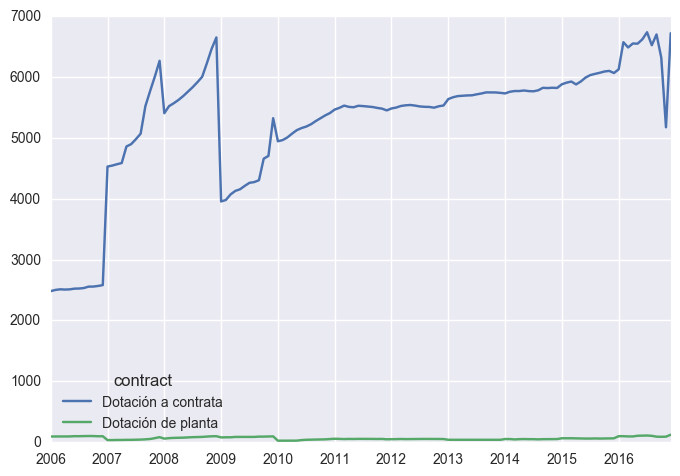

In [38]:
dfsename.ix[dfsename.include == 1].replace(np.nan, -1).groupby('contract').resample('M')['curDate2'].count().unstack('contract').plot()

Looking more reasonable, there are some strange spikes at the end of 2007, 2008 and 2009.

In [39]:
dfsename.ix[dfsename.include == 1].replace(np.nan, -1).groupby('contract').resample('M')['curDate2'].count().unstack('contract')

contract,Dotación a contrata,Dotación de planta
2006-01-31,2482,95
2006-02-28,2502,95
2006-03-31,2512,96
2006-04-30,2508,95
2006-05-31,2511,96
2006-06-30,2523,100
2006-07-31,2525,100
2006-08-31,2533,102
2006-09-30,2556,103
2006-10-31,2557,102


## Can we translate the count into value?

In [40]:
dfsename['salary2'] = dfsename['salary'].replace('\.', '', regex=True)
dfsename.salary2 = dfsename.salary2.astype(float)
dfsename.salary2.value_counts().head()

0.0          259409
1580920.0      1660
1185921.0      1332
1442751.0      1212
1426835.0      1188
Name: salary2, dtype: int64

* There are too many zeroes, checking.
* There are some values that are far too popular, checking source too

In [41]:
dfsename.ix[dfsename.salary2 == 0].groupby(['curDate2'])['entity'].count().sort_index()

curDate2
2006-01-01    2808
2006-02-01    2808
2006-03-01    2808
2006-04-01    2808
2006-05-01    2808
2006-06-01    2808
2006-07-01    2808
2006-08-01    2808
2006-09-01    2808
2006-10-01    2808
2006-11-01    2808
2006-12-01    2808
2007-01-01    6370
2007-02-01    6370
2007-03-01    6370
2007-04-01    6370
2007-05-01    6370
2007-06-01    6370
2007-07-01    6370
2007-08-01    6370
2007-09-01    6370
2007-10-01    6370
2007-11-01    6370
2007-12-01    6370
2008-01-01    6774
2008-02-01    6774
2008-03-01    6774
2008-04-01    6774
2008-05-01    6774
2008-06-01    6774
              ... 
2014-07-01      19
2014-08-01      19
2014-09-01      19
2014-10-01      19
2014-11-01      19
2014-12-01      19
2015-01-01      18
2015-02-01      18
2015-03-01      18
2015-04-01      18
2015-05-01      18
2015-06-01      18
2015-07-01      18
2015-08-01      18
2015-09-01      18
2015-10-01      18
2015-11-01      18
2015-12-01      18
2016-01-01      51
2016-02-01      26
2016-03-01      18
201

In [42]:
dfsename.ix[(dfsename.salary2 == 0) & (dfsename.curDate2 == datetime(year=2014, month=7, day=1)), 'url'].value_counts()

http://www.gobiernotransparentechile.cl/directorio/entidad/11/159/per_contrata/Ao-2014?x=0&y=0&page_number=17&sort=id&direction=asc    4
http://www.gobiernotransparentechile.cl/directorio/entidad/11/159/per_contrata/Ao-2014?x=0&y=0&page_number=18&sort=id&direction=asc    3
http://www.gobiernotransparentechile.cl/directorio/entidad/11/159/per_contrata/Ao-2014?x=0&y=0&page_number=19&sort=id&direction=asc    2
http://www.gobiernotransparentechile.cl/directorio/entidad/11/159/per_contrata/Ao-2014?x=0&y=0&page_number=39&sort=id&direction=asc    2
http://www.gobiernotransparentechile.cl/directorio/entidad/11/159/per_contrata/Ao-2014?x=0&y=0&page_number=4&sort=id&direction=asc     1
http://www.gobiernotransparentechile.cl/directorio/entidad/11/159/per_contrata/Ao-2014?x=0&y=0&page_number=38&sort=id&direction=asc    1
http://www.gobiernotransparentechile.cl/directorio/entidad/11/159/per_contrata/Ao-2014?x=0&y=0&page_number=33&sort=id&direction=asc    1
http://www.gobiernotransparentechile.cl/d

The zeroes in 2014 and over are because of people who resigned

In [43]:
dfsename.columns

Index(['TmonthIsKnownYear', 'contract', 'currency', 'degree', 'department',
       'end_date', 'entity', 'filename', 'givenn', 'group', 'include', 'lastn',
       'lastn2', 'month', 'month2', 'month3', 'obs', 'other', 'overt',
       'position', 'qualif', 'region', 'salary', 'specials', 'start_date',
       'url', 'year', 'year2', 'curDate', 'curDate2', 'start_date2',
       'end_date2', 'TcorrectedDate', 'salary2'],
      dtype='object')

In [44]:
dfsename.ix[dfsename.salary2 == 1580920.0].groupby(['curDate2', 'givenn', 'lastn', 'lastn2' ])['entity'].count()

curDate2    givenn                lastn       lastn2    
2015-01-01  alba lorena           valdes      jaque         1
            alejandra andrea      henriquez   fuenzalida    1
            alejandra leticia     contreras   salinas       1
            alice joyce purisima  reichel     hernandez     1
            ana lucia             rojas       vasquez       1
            andres jose           sovier      peña          2
            carlos dario          gonzalez    subiabre      1
            carolina andrea       moyano      vasquez       2
            claudia ines          diaz        alarcon       1
            cristian rodrigo      aguilera    hansen        1
            daniela angelique     catalan     basaure       1
            daniella angela       orsola      gnecco        1
            danniela paz          gomez       perez         1
            david alfredo         saavedra    fuentes       1
            emita elvira          parra       caceres       1
            g

This popular salary is spread across several people

## There seems to be duplicated names. Checking

In [50]:
dfsename.ix[(dfsename.givenn == 'miguel angel') & (dfsename.include == 1) & (dfsename.curDate2 == datetime(year=2016, month=6, day=1))].to_csv('./output/doublename.csv')#

In [51]:
dfsename.ix[dfsename.include == 1].groupby(['curDate2', 'givenn', 'lastn', 'lastn2'])['entity'].count().sort_values(ascending=False)

curDate2    givenn                lastn       lastn2    
2007-06-01                                                  6
2008-10-01                                                  6
2007-12-01                                                  6
2016-06-01  miguel angel          avendaño    canales       6
2008-04-01                                                  6
2007-02-01                                                  6
2008-06-01                                                  6
2008-09-01                                                  6
2008-11-01                                                  6
2007-09-01                                                  6
2007-03-01                                                  6
2007-07-01                                                  6
2007-08-01                                                  6
2011-08-01  claudia del pilar     peña        araneda       6
2016-08-01  miguel angel          avendaño    canales       6
2008-08-01   